In [1]:
#text clustering
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
df = pd.read_csv('/content/drive/My Drive/cut.csv')
df.head()

,id,topic,heading,summary,date,sub-heading,content,tags
0,5ef0d321d83b3587cb500efc,"[""football""]","[""VAR not being used correctly: Barcelona coac...","[""Barcelona had a goal ruled out by VAR for of...","[""Updated: Jun 22, 2020 20:03 IST""]","[""Reuters""]","[""The Video Assistant Referee (VAR) system is ...","[""Quique Setien"",""Barcelona""]"
1,5ef0d324d83b3587cb500efd,"[""football""]","[""Mourinho hits back at Merson’s criticism of ...","[""Merson, a pundit with Sky Sports, said 26-ye...","[""Updated: Jun 22, 2020 20:30 IST""]","[""Reuters""]","[""Jose Mourinho launched an impassioned defenc...","[""Jose Mourinho"",""Harry Kane"",""Manchester unit..."
2,5efff14f86936ae10d2be3c8,"[""football""]","[""Morata double leads Atletico to 3-0 win over...","[""Morata earned a penalty when he was pulled d...","[""Updated: Jul 04, 2020 07:12 IST""]","[""Associated Press""]","[""Alvaro Morata scored twice to lead Atletico ...","[""Alvaro Morata"",""Mallorca"",""Diego Simeone"",""R..."
3,5efff10a86936ae10d2be3aa,"[""cricket""]","[""Sourav Ganguly made Sehwag open, brought in ...","[""Former India opener Wasim Jaffer, who made h...","[""Updated: Jul 04, 2020 08:03 IST""]","[""hindustantimes.com""]","[""Despite not being able to lead India to an I...","[""Sourav Ganguly"",""Wasim Jaffer"",""India"",""Zahe..."
4,5ef0d2e5d83b3587cb500edf,"[""cricket""]","[""Jasprit Bumrah is ‘a different beast’ when h...","[""The man in charge of the team currently is h...","[""Updated: Jun 22, 2020 20:57 IST""]","[""hindustantimes.com""]","[""Mumbai Indians are the most successful team ...","[""Mumbai Indians"",""Jasprit Bumrah"",""Mahela Jay..."


In [ ]:
df.heading[1]

'["‘Sino-India ties will deteriorate further’: Ex-envoy to China on Galwan faceoff\xa0 \xa0"]'

In [3]:
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import re

In [4]:
# data preprocessing
stemmer = SnowballStemmer(language='english',ignore_stopwords=True)
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [5]:
# preview after preprocessing
doc_sample = df.heading[1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['["Mourinho', 'hits', 'back', 'at', 'Merson’s', 'criticism', 'of', 'playing', 'style,', 'Kane’s', 'record"]']


 tokenized and lemmatized document: 
['mourinho', 'hit', 'merson', 'critic', 'play', 'style', 'kane', 'record']


In [6]:
# Preprocess the headline text, saving the results as ‘processed_docs’
#df['processed_heading'] = df['heading'].map(preprocess)
df['processed_content'] = df['content'].map(preprocess)
#processed_docs.head(5)
#df.head()
#df['processed_heading'] = df['processed_heading'].apply(lambda x: ' '.join(x))
df['processed_content'] = df['processed_content'].apply(lambda x: ' '.join(x))
df['processed_content'][0]

'video assist refere correct liga barcelona manag quiqu setien say monday follow real madrid controversi real sociedad madrid beat sociedad climb barcelona liga home aggriev goal rule offsid karim benzema winner stand appear control ball thing control depend everybodi happen anoeta draw conclus setien tell report ahead tuesday match athlet bilbao understand think action review refere review play match think correct setien say controversi footbal year chang controversi add tool better clearer view realiti point real stand superior head head record setien convinc titl race barcelona hand margin error smaller smaller say madrid mistak leagu decid game leav madrid play difficult game like'

In [7]:
#feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_content.values)
features = vec.transform(df.processed_content.values)

In [8]:
#model training
random_state = 0
cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [9]:
#predict on new data
cls.predict(features)

array([2, 2, 2, 2, 2, 2, 2, 4, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0], dtype=int32)

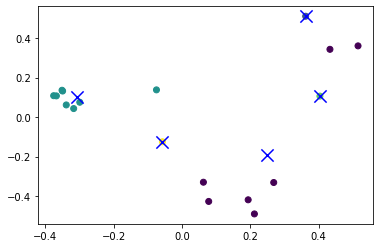

In [10]:
#visualization
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [11]:
#evaluation with labelled dataset
from sklearn.metrics import homogeneity_score
homogeneity_score(df.heading, cls.predict(features))

0.41843499131272865

In [12]:

#evaluation with unlabelled dataset
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

-0.009389445794317369

In [13]:
#topic modelling
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

random_state = 0

def only_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output


df['noun_content'] = only_nouns(df['content'])

df.head()

,id,topic,heading,summary,date,sub-heading,content,tags,processed_content,noun_content
0,5ef0d321d83b3587cb500efc,"[""football""]","[""VAR not being used correctly: Barcelona coac...","[""Barcelona had a goal ruled out by VAR for of...","[""Updated: Jun 22, 2020 20:03 IST""]","[""Reuters""]","[""The Video Assistant Referee (VAR) system is ...","[""Quique Setien"",""Barcelona""]",video assist refere correct liga barcelona man...,"var system manager win "",""madrid top home side..."
1,5ef0d324d83b3587cb500efd,"[""football""]","[""Mourinho hits back at Merson’s criticism of ...","[""Merson, a pundit with Sky Sports, said 26-ye...","[""Updated: Jun 22, 2020 20:30 IST""]","[""Reuters""]","[""Jose Mourinho launched an impassioned defenc...","[""Jose Mourinho"",""Harry Kane"",""Manchester unit...",jose mourinho launch impass defenc harri kane ...,defence form playing style television pundit s...
2,5efff14f86936ae10d2be3c8,"[""football""]","[""Morata double leads Atletico to 3-0 win over...","[""Morata earned a penalty when he was pulled d...","[""Updated: Jul 04, 2020 07:12 IST""]","[""Associated Press""]","[""Alvaro Morata scored twice to lead Atletico ...","[""Alvaro Morata"",""Mallorca"",""Diego Simeone"",""R...",alvaro morata score twice lead atletico madrid...,win finish league team title race leader point...
3,5efff10a86936ae10d2be3aa,"[""cricket""]","[""Sourav Ganguly made Sehwag open, brought in ...","[""Former India opener Wasim Jaffer, who made h...","[""Updated: Jul 04, 2020 08:03 IST""]","[""hindustantimes.com""]","[""Despite not being able to lead India to an I...","[""Sourav Ganguly"",""Wasim Jaffer"",""India"",""Zahe...",despit abl lead india trophi sole india joint ...,trophy winner captain number captain test cric...
4,5ef0d2e5d83b3587cb500edf,"[""cricket""]","[""Jasprit Bumrah is ‘a different beast’ when h...","[""The man in charge of the team currently is h...","[""Updated: Jun 22, 2020 20:57 IST""]","[""hindustantimes.com""]","[""Mumbai Indians are the most successful team ...","[""Mumbai Indians"",""Jasprit Bumrah"",""Mahela Jay...",mumbai indian success team histori indian prem...,team history team title cliffhanger season vic...


In [14]:
# change this to see different results using the components_ attribute
n_topics = 5

#for extracting features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vec.fit_transform(df.noun_content)

#for topic modelling

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [15]:
# list of unique words found by the vectorizer
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 teacher government student class school minister state college teaching child education method case need order 
1 test team captain player people coach field cricket series tournament head squad job skipper franchise 
2 result exam class student board 10th assessment subject lakh examination mark year need credential school 
3 league goal game match ball point striker playing injury controversy head title referee play race 
4 fee school lockdown parent period plea relief court class student government authority order state decision 


In [16]:
# to identify topic of a new document
new_articles = [
    "Government declared holidays of coaching classes upto November",
    "Germany scored 7 goals against Brazil in worldcup semi-finals"
]
# first transform the text into features using vec
# then pass it to transform of cls
# the result will be a matrix of shape [2, 10]
# then we sort the topic id based on the score using argsort
# and take the last one (with the highest score) for each row using `[:,-1]` indexing
cls.transform(vec.transform(new_articles)).argsort(axis=1)[:,-1]

array([0, 4])